In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import time
import datashader as ds

import sys
sys.path.insert(0, '/cndd2/fangming/projects/SingleCellRoutines')
from __init__scr import *
import utils
import powerplot

- v1 - not used
- v2 - current (works)
- v3 - add rna
- v4 - remove enhancers with <100bp

In [2]:
!ls /cndd2/fangming/projects/scf_enhancers/cicero/ 

0-try_cicero.R
1-organize_mop_data_for_cicero.ipynb
1-tweak_cicero.R
1-v2-organize_mop_data_for_cicero.ipynb
2-run_mop_cicero_k50.R
2-run_mop_cicero.R
3-run_mop_cicero_pbulks.R
atac_peak_by_cell_mat_mop.txt.gz
atac_peak_by_cluster_mat_mop_ethan38.txt.gz
atac_promoter_and_peak_by_cell_mat_mop.txt.gz
atac_promoter_by_cell_mat_mop.txt.gz
cicero_mop_out_test.csv
cicero_mop_out_test_k50.csv
cicero.Rproj
gencode_vM16_genes_19x_promoters_500.bed
kidney_data.txt.gz
log.1
log.2
log.2_k50
log.3
mm10.chrom.sizes.ordered
old
packrat
Rplots.pdf
Untitled.ipynb


In [3]:
# read
ti = time.time()
f = '/cndd2/fangming/projects/scf_enhancers/cicero/cicero_mop_out_test_k50.csv'
cicero = pd.read_csv(f)
print(time.time()-ti)
print(cicero.shape)
cicero

# # categorize
# default_th = 0.2
# cond_sigcicero = (cicero['powerlaw.Score'] > default_th)
# scorecat, bins = pd.qcut(cicero['powerlaw.Score'][cond_sigcicero], 3, retbins=True, labels=['1-low', '2-mid', '3-high'])
# cicero = cicero.join(scorecat.to_frame('cicero_cat'))
# print(time.time()-ti)

# print(cond_sigcicero.sum())
# print(bins)

# print(cicero.columns)
# print(cicero.shape)
# cicero

13.447609186172485
(30429098, 4)


,Unnamed: 0,Peak1,Peak2,coaccess
0,1,chr10_100009732_100010967,chr10_99759006_99759506,0.00000
1,2,chr10_100009732_100010967,chr10_99759658_99760158,0.00000
2,3,chr10_100009732_100010967,chr10_99774258_99774624,0.00000
3,4,chr10_100009732_100010967,chr10_99811964_99812079,0.00000
4,5,chr10_100009732_100010967,chr10_99825585_99826381,0.05058
...,...,...,...,...
30429093,30711865,chrX_99994750_99994927,chrX_100077185_100077279,0.00000
30429094,30711866,chrX_99994750_99994927,chrX_100126838_100127004,0.00000
30429095,30711867,chrX_99994750_99994927,chrX_100156135_100156635,0.00000
30429096,30711868,chrX_99994750_99994927,chrX_100192791_100192819,0.00000


# turn it into an enhancer-gene pair table

In [4]:
cicero['Peak1'].unique().shape, cicero['Peak2'].unique().shape

((282771,), (282771,))

<ipython-input-50-7c9ac02f209f>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.distplot(cicero[cond]['coaccess'])


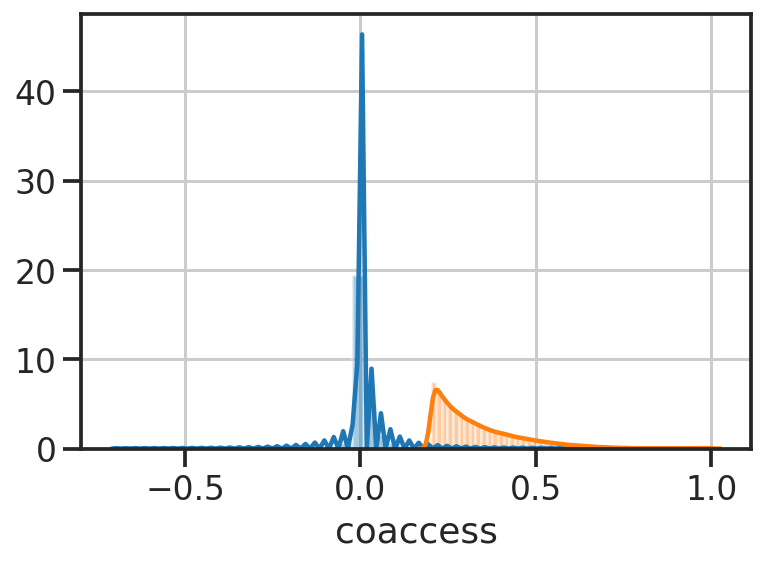

In [50]:
sns.distplot(cicero['coaccess'])

cond = cicero['coaccess'] > 0.2
cicero = cicero[cond]
sns.distplot(cicero[cond]['coaccess'])

In [51]:
import pickle

f = '/cndd2/fangming/projects/scf_enhancers/data/organized_cell_level/version_nov9/enh.tsv'
with open(f, 'rb') as fh:
    enhs = pickle.load(fh)
    enhs['region'] = ('chr'+enhs['chr']+'_'+enhs['start'].astype(str)+'_'+enhs['end'].astype(str))
    enhs['annot'] = 'enh'
enhs

,chr,start,end,region,annot
0,1,3083769,3083816,chr1_3083769_3083816,enh
1,1,3112234,3112467,chr1_3112234_3112467,enh
2,1,3112770,3112986,chr1_3112770_3112986,enh
3,1,3113717,3114035,chr1_3113717_3114035,enh
4,1,3118790,3118935,chr1_3118790_3118935,enh
...,...,...,...,...,...
233509,X,169837855,169838443,chrX_169837855_169838443,enh
233510,X,169857939,169858058,chrX_169857939_169858058,enh
233511,X,169890644,169890829,chrX_169890644_169890829,enh
233512,X,169918008,169918093,chrX_169918008_169918093,enh


In [52]:
f = '/cndd2/fangming/projects/scf_enhancers/data/organized_cell_level/version_nov9/region_promoters_snatac_gene.pkl'
with open(f, 'rb') as fh:
    promos = pickle.load(fh)
    promos['annot'] = promos['gid']
promos

,chr,start,end,gid,gene_name,region,annot
0,chr10,100015130,100015630,ENSMUSG00000019966,Kitl,chr10_100015130_100015630,ENSMUSG00000019966
1,chr10,100139001,100139501,ENSMUSG00000096586,Gm22918,chr10_100139001_100139501,ENSMUSG00000096586
2,chr10,100143754,100144254,ENSMUSG00000095539,Gm25287,chr10_100143754_100144254,ENSMUSG00000095539
3,chr10,100144126,100144626,ENSMUSG00000112831,AC167229.2,chr10_100144126_100144626,ENSMUSG00000112831
4,chr10,100204342,100204842,ENSMUSG00000112633,AC167229.1,chr10_100204342_100204842,ENSMUSG00000112633
...,...,...,...,...,...,...,...
51735,chrX,99471273,99471773,ENSMUSG00000034403,Pja1,chrX_99471273_99471773,ENSMUSG00000034403
51736,chrX,99687774,99688274,ENSMUSG00000082505,Gm14816,chrX_99687774_99688274,ENSMUSG00000082505
51737,chrX,99795971,99796471,ENSMUSG00000083682,Pcna-ps1,chrX_99795971_99796471,ENSMUSG00000083682
51738,chrX,99820521,99821021,ENSMUSG00000071719,Tmem28,chrX_99820521_99821021,ENSMUSG00000071719


In [53]:
regions_annot = pd.concat([
        enhs[['region', 'annot']], 
        promos[['region', 'annot']],
        ]).set_index('region')
regions_annot

,annot
region,
chr1_3083769_3083816,enh
chr1_3112234_3112467,enh
chr1_3112770_3112986,enh
chr1_3113717_3114035,enh
chr1_3118790_3118935,enh
...,...
chrX_99471273_99471773,ENSMUSG00000034403
chrX_99687774_99688274,ENSMUSG00000082505
chrX_99795971_99796471,ENSMUSG00000083682


In [54]:
pcicero = cicero.copy()
pcicero['peak1_annot'] = regions_annot.loc[cicero['Peak1'].values].values
pcicero['peak2_annot'] = regions_annot.loc[cicero['Peak2'].values].values
pcicero['nenh'] = (pcicero['peak1_annot'] == 'enh').astype(int) + (pcicero['peak2_annot'] == 'enh').astype(int)
print(pcicero.value_counts('nenh'))
pcicero

nenh
2    296106
0    135498
dtype: int64


,Unnamed: 0,Peak1,Peak2,coaccess,peak1_annot,peak2_annot,nenh
46,48,chr10_100009732_100010967,chr10_100054036_100054759,0.252253,enh,enh,2
168,171,chr10_100015130_100015630,chr10_100487058_100487558,0.444206,ENSMUSG00000019966,ENSMUSG00000019971,0
169,172,chr10_100015130_100015630,chr10_100487350_100487850,0.455519,ENSMUSG00000019966,ENSMUSG00000036676,0
180,183,chr10_100018530_100019593,chr10_99857969_99858788,0.207062,enh,enh,2
204,208,chr10_100018530_100019593,chr10_100019604_100019864,0.403102,enh,enh,2
...,...,...,...,...,...,...,...
30427096,30709839,chrX_99575245_99575683,chrX_99519849_99520891,0.280649,enh,enh,2
30427104,30709847,chrX_99575245_99575683,chrX_99547521_99548773,0.283098,enh,enh,2
30428258,30711015,chrX_99691087_99691457,chrX_99519849_99520891,0.218269,enh,enh,2
30428755,30711520,chrX_99820521_99821021,chrX_99975106_99975606,0.369150,ENSMUSG00000071719,ENSMUSG00000059327,0


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


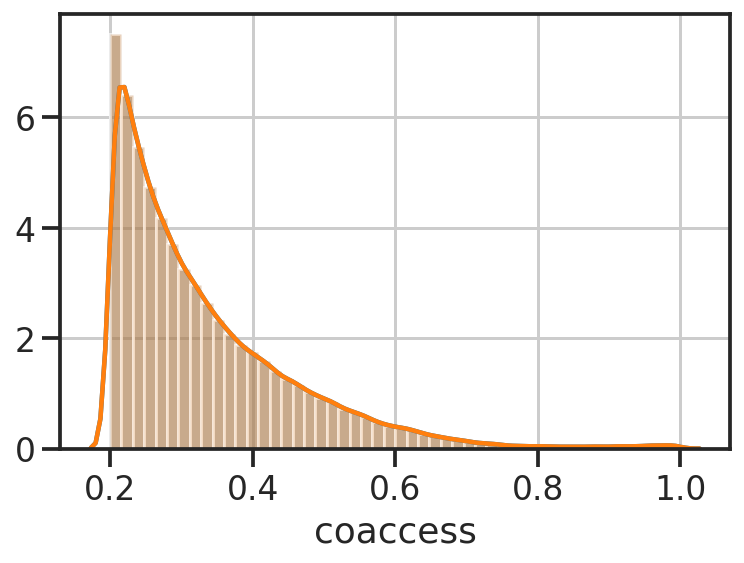

In [55]:
sns.distplot(cicero['coaccess'])

cond = cicero['coaccess'] > 0.2
sns.distplot(cicero[cond]['coaccess'])

sns.distplot(pcicero[pcicero['nenh']==1]['coaccess'])

In [56]:
# get enh - gene links only, and put enhs as peak1
dcicero = pcicero[pcicero['nenh']==1].copy()

part1 = dcicero[dcicero['peak1_annot']=='enh'].copy()
part2 = dcicero[dcicero['peak2_annot']=='enh'].copy().rename(columns={
    'Peak1': 'Peak2',
    'Peak2': 'Peak1',
    'peak1_annot': 'peak2_annot',
    'peak2_annot': 'peak1_annot',
})

dcicero = pd.concat([part1, part2])
print((dcicero['peak2_annot'] == 'enh').sum())
dcicero

0


,Unnamed: 0,Peak1,Peak2,coaccess,peak1_annot,peak2_annot,nenh


In [11]:
def get_distance(region):
    chrom, start, end = region.split('_')
    dis = int(end)+int(start)/2
    return dis

dcicero['peak1_dis'] = dcicero['Peak1'].apply(get_distance)
dcicero['peak2_dis'] = dcicero['Peak2'].apply(get_distance)
dcicero['distance'] = np.abs(dcicero['peak1_dis']-dcicero['peak2_dis'])
dcicero

,Unnamed: 0,Peak1,Peak2,coaccess,peak1_annot,peak2_annot,nenh,peak1_dis,peak2_dis,distance
0,1,chr10_100009732_100010967,chr10_99759006_99759506,0.000000,enh,ENSMUSG00000112304,1,150015833.0,149639009.0,376824.0
1,2,chr10_100009732_100010967,chr10_99759658_99760158,0.000000,enh,ENSMUSG00000046934,1,150015833.0,149639987.0,375846.0
13,14,chr10_100009732_100010967,chr10_99866020_99866520,0.000000,enh,ENSMUSG00000112463,1,150015833.0,149799530.0,216303.0
31,32,chr10_100009732_100010967,chr10_99988121_99988621,0.000000,enh,ENSMUSG00000112299,1,150015833.0,149982681.5,33151.5
32,34,chr10_100009732_100010967,chr10_100015130_100015630,-0.141739,enh,ENSMUSG00000019966,1,150015833.0,150023195.0,7362.0
...,...,...,...,...,...,...,...,...,...,...
30429004,30711774,chrX_100028984_100029166,chrX_99975106_99975606,0.000000,enh,ENSMUSG00000059327,1,150043658.0,149963159.0,80499.0
30429005,30711775,chrX_100077185_100077279,chrX_99975106_99975606,0.000000,enh,ENSMUSG00000059327,1,150115871.5,149963159.0,152712.5
30429006,30711776,chrX_100126838_100127004,chrX_99975106_99975606,0.000000,enh,ENSMUSG00000059327,1,150190423.0,149963159.0,227264.0
30429008,30711778,chrX_100192791_100192819,chrX_99975106_99975606,0.000000,enh,ENSMUSG00000059327,1,150289214.5,149963159.0,326055.5


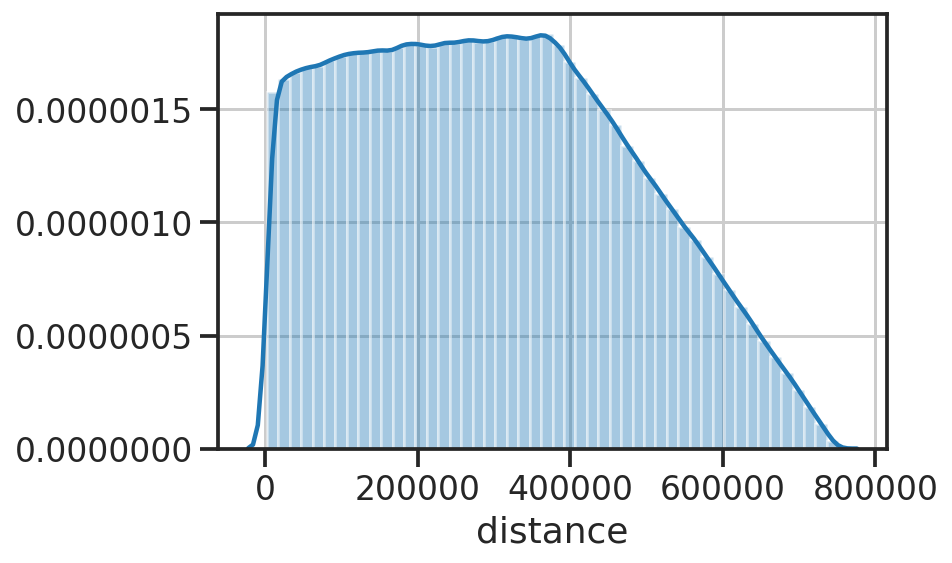

In [12]:
sns.distplot(dcicero['distance'])

In [13]:
def change_region_format(region):
    """chr?_xxx_xxx -> chr?:xxx-xxx
    """
    newregion = region.replace('_', ':', 1).replace('_', '-')
    return newregion
    
    
fcicero = dcicero[dcicero['distance']<=1e5].rename(columns={'Peak1': 'enh_name', 'peak2_annot': 'TargetGene'})[
    ['enh_name', 'TargetGene', 'coaccess']].copy()
fcicero['enh_name'] = fcicero['enh_name'].apply(change_region_format)
fcicero

,enh_name,TargetGene,coaccess
31,chr10:100009732-100010967,ENSMUSG00000112299,0.000000
32,chr10:100009732-100010967,ENSMUSG00000019966,-0.141739
201,chr10:100018530-100019593,ENSMUSG00000112299,0.000000
203,chr10:100018530-100019593,ENSMUSG00000019966,-0.179104
286,chr10:100019604-100019864,ENSMUSG00000112299,0.000000
...,...,...,...
30428752,chrX:99825953-99826130,ENSMUSG00000071719,-0.007729
30428753,chrX:99843824-99844135,ENSMUSG00000071719,0.000000
30428754,chrX:99853186-99853303,ENSMUSG00000071719,0.000000
30429003,chrX:99994750-99994927,ENSMUSG00000059327,-0.042034


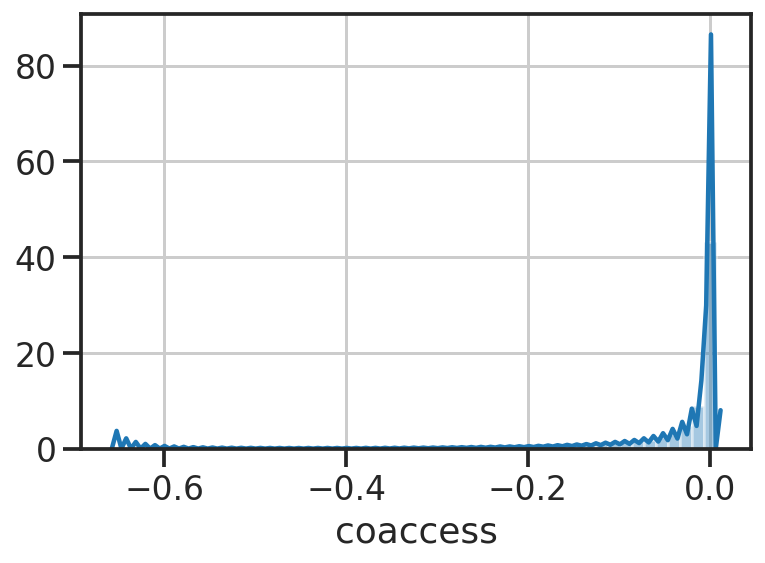

In [14]:
sns.distplot(fcicero['coaccess'])

In [15]:
(fcicero['coaccess'] > 0).sum()

1440

# Compare with my predictions 

In [16]:
import sys
import importlib
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
sys.path.insert(0, '/cndd2/fangming/projects/scf_enhancers/scripts/scf_enhancer_paper')
from __init__ import *
import __init__jupyterlab
importlib.reload(__init__jupyterlab)
from __init__jupyterlab import *

import re 
import tqdm
import pickle
import collections
import itertools
import tables

from scipy import sparse
from scipy import stats
from scipy import optimize 
import scipy.cluster.hierarchy as sch
from statsmodels.stats.multitest import multipletests

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_clst_utils
importlib.reload(CEMBA_clst_utils)
import enhancer_gene_utils 
importlib.reload(enhancer_gene_utils)

<module 'enhancer_gene_utils' from '/cndd2/fangming/projects/scf_enhancers/scripts/scf_enhancer_paper/enhancer_gene_utils.py'>

In [17]:
import datetime
today = datetime.date.today().strftime("%y%m%d")
CORRCOEF_TYPE = 'Spearmanr' # Pearsonr
print(today)

210818


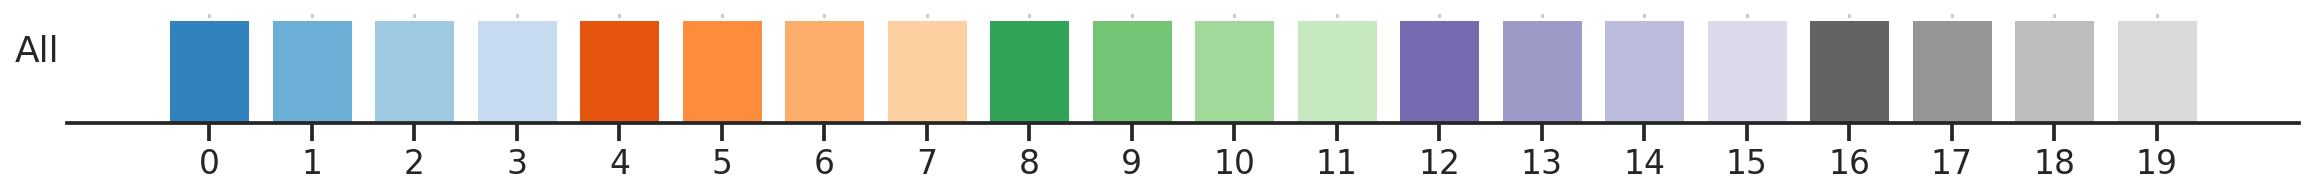

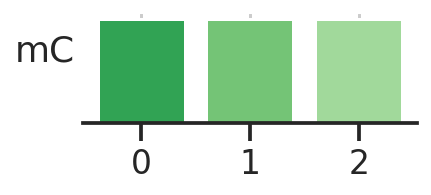

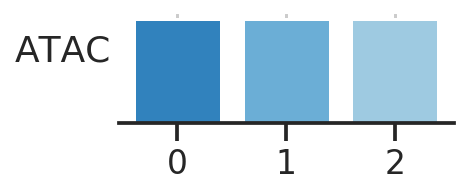

/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/matplotlib/colors.py:235: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


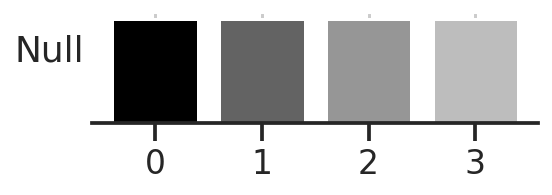

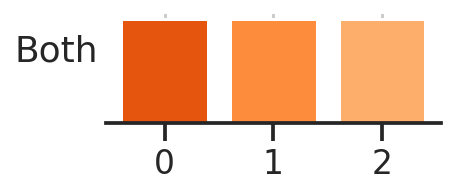

In [18]:
# color palette
cm = plt.cm.tab20c.colors

# settle down on a color palette
colors_mc = [cm[8], cm[9], cm[10],]
colors_atac = [cm[0], cm[1], cm[2],]
colors_both = [cm[4], cm[5], cm[6],]
colors_null = ['black', cm[16], cm[17], cm[18],]

color_tracks = [
    cm,
    colors_mc,
    colors_atac,
    colors_null,
    colors_both,
]

labels = [
    'All',
    'mC',
    'ATAC',
    'Null',
    'Both',
]


for color_track, label in zip(color_tracks, labels):
    n = len(color_track)
    fig, ax = plt.subplots(figsize=(1*n,1))
    ax.bar(np.arange(n), 1, 
           color=color_track)
    ax.set_xticks(np.arange(n))
    ax.set_ylabel(label, rotation=0, ha='right')
    sns.despine(ax=ax, left=True)
    ax.set_yticks([])
    plt.show()

In [19]:
mod_palette = {
    'mc': 'C2',
    'atac': 'C0',
    'null': 'k',
}

mod_palette_comp = {
    'mc': colors_mc,
    'atac': colors_atac,
    'null': colors_null,
}

KB = 1000

def p25(x):
    return np.nanpercentile(x, 25)

def p75(x):
    return np.nanpercentile(x, 75)

def strip_gid_suffix(gid):
    """
    """
    if isinstance(gid, str):
        gid_new = gid.split('.')[0]
    else:
        gid_new = ''
    return gid_new

In [20]:
# genes
# enhs
# to_evals
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/organized_for_jupyter/genes_list.tsv'
genes_list = pd.read_csv(f, sep='\t', index_col=False)
print(genes_list.shape)

# enh list
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/organized_for_jupyter/enhs_list.tsv'
enh_list = pd.read_csv(f, sep='\t', index_col=False)
print(enh_list.shape)

# pair list
f = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals_appended_201212.tsv' 
to_evals = pd.read_csv(f, sep='\t', index_col=False)
to_evals = to_evals.astype({'dist': np.int, 'enh': np.int, 'is_in_genebody': np.bool_})
print(to_evals.shape)

(31053, 11)
(233514, 7)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(2589994, 4)


<ipython-input-20-22243a218237>:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  to_evals = to_evals.astype({'dist': np.int, 'enh': np.int, 'is_in_genebody': np.bool_})


In [21]:
gid_to_gname = genes_list.groupby('gid').first()['gene_name'] 
gname_to_gid = genes_list.groupby('gene_name').first()['gid']
def gname_to_gid_nan(name):
    try:
        return gname_to_gid[name]
    except:
        return np.nan

In [22]:
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/organized_for_jupyter/enhancer_nearest_genes.bed'
regions_info = pd.read_csv(f, sep='\t', header=None, dtype={0: str, 4: str}, 
                           names=['chr', 'start', 'end', 
                                  'trpt_chr', 'trpt_start', 'trpt_end', 
                                  'strand', 
                                  'trpt_id', 'trpt_name',
                                  'gene_id', 'gene_name',
                                  'dist',
                                 ]
                          )

print(regions_info.shape)
print(enh_list.shape)
# expand enh_list
enh_list_expand = pd.merge(enh_list, regions_info, on=['chr', 'start', 'end'], how='left')
enh_list_expand['name'] = enh_list_expand['chr']+':'+enh_list_expand['start'].astype(str)+"-"+enh_list_expand['end'].astype(str)
print(enh_list_expand.shape)
enh_list_expand.head()

(233514, 12)
(233514, 7)
(233514, 17)


,index,chr,start,end,length,chrom,center,trpt_chr,trpt_start,trpt_end,strand,trpt_id,trpt_name,gene_id,gene_name,dist,name
0,0,chr1,3083769,3083816,47,1,3083792,chr1,3073253,3073254,+,ENSMUST00000193812.1,4933401J01Rik-201,ENSMUSG00000102693.1,4933401J01Rik,10516,chr1:3083769-3083816
1,1,chr1,3112234,3112467,233,1,3112350,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,10218,chr1:3112234-3112467
2,2,chr1,3112770,3112986,216,1,3112878,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,10754,chr1:3112770-3112986
3,3,chr1,3113717,3114035,318,1,3113876,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,11701,chr1:3113717-3114035
4,4,chr1,3118790,3118935,145,1,3118862,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,16774,chr1:3118790-3118935


# Analysis 

In [23]:
# get all clusterings
def get_isub_clstfile(fname):
    """Subsampling index
    """
    pattern = '_sub[0-9]+.tsv.gz' 
    isub = int(re.findall(pattern, fname)[0][len("_sub"):-len('.tsv.gz')])
    return isub 

def get_knn_clstfile(fname):
    """cross-modal knn
    """
    pattern = '_knn[0-9]+_' 
    knn = int(re.findall(pattern, fname)[0][len("_knn"):-len('_')])
    return knn 

f_pattern = ("/cndd2/fangming/projects/miniatlas/results/"
             "clusterings_10x_cells_v3_mop_10x_cells_v3_snatac_gene_ka30_knn*_201206_sub*.tsv.gz"
             )
fnames = np.sort(glob.glob(f_pattern))
iterator_clsts = pd.DataFrame([{'i': get_isub_clstfile(fname),
                                'k': get_knn_clstfile(fname),
                                'fname': fname,
                              } for fname in fnames])
print(iterator_clsts.shape)

res_clsts = []
for idx, row in tqdm.tqdm(iterator_clsts.iterrows()):
    isub = row['i']
    knn = row['k']
    fname = row['fname']
    
    df = pd.read_csv(fname, index_col=0, sep='\t')
    for col in df.columns:
        r = float(col[len('cluster_r'):])
        num_clst = len(df[col].unique())
        res_clsts.append({
            'k': knn,
            'i': isub,
            'r': r,
            'num_clst': num_clst,
        })
#     break
res_clsts = pd.DataFrame(res_clsts)
print(res_clsts.shape)

0it [00:00, ?it/s]

(1, 3)


1it [00:00,  3.59it/s]

(41, 4)


In [24]:
# get all (shared) corr analyses
def get_resolution(fname):
    """Resolution
    """
    resolution_pattern = '_cluster_r[0-9.]+_' 
    r = float(re.findall(resolution_pattern, fname)[0][len("_cluster_r"):-len('_')])
    return r
    
def get_isub(fname):
    """Subsampling index
    """
    pattern = '_[0-9]_cluster' 
    isub = int(re.findall(pattern, fname)[0][len("_"):-len('_cluster')])
    return isub 

def get_knn(fname):
    """cross-modal knn
    """
    pattern = '_knn[0-9]+_' 
    knn = int(re.findall(pattern, fname)[0][len("_knn"):-len('_')])
    return knn 

# mC
f_pattern = ("/cndd2/fangming/projects/scf_enhancers/results/"
             "mop_10x_cells_v3_snmcseq_gene_ka30_knn*_201206"
             "_[0-9]_cluster_r*_spearmanr_corrs.pkl"
            )
fnames = np.sort(glob.glob(f_pattern))
iterator_mc = pd.DataFrame([{'r': get_resolution(fname),
                             'i': get_isub(fname),
                             'k': get_knn(fname),
                             'fname_mc': fname,
                          } for fname in fnames])
print(iterator_mc.shape)

# ATAC
f_pattern = ("/cndd2/fangming/projects/scf_enhancers/results/"
             "mop_10x_cells_v3_snatac_gene_ka30_knn*_201206"
             "_[0-9]_cluster_r*_spearmanr_corrs.pkl"
            )
fnames = np.sort(glob.glob(f_pattern))
iterator_atac = pd.DataFrame([{'r': get_resolution(fname),
                               'i': get_isub(fname),
                               'k': get_knn(fname),
                               'fname_atac': fname,
                              } for fname in fnames])
print(iterator_atac.shape)

# both
iterator_both = pd.merge(iterator_mc, iterator_atac, on=['k', 'r', 'i'])
iterator_both = pd.merge(iterator_both, res_clsts)
print(iterator_both.shape)
iterator_both.sort_values('r')

(30, 4)
(21, 4)
(21, 6)


,r,i,k,fname_mc,fname_atac,num_clst
0,1.000000,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,16
1,1.258925,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,18
2,1.584893,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,22
3,1.995262,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,28
9,2.511886,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,34
11,3.162278,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,39
12,3.981072,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,52
15,5.011872,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,62
17,6.309573,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,75
19,7.943282,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,90


# one analysis 

In [25]:
# choose 1 (r=100; num_clst=935) to proceed 
num_clst = 256
fname1, fname2, resolution = iterator_both[iterator_both['num_clst']==num_clst][['fname_mc', 'fname_atac', 'r']].iloc[0]
print(fname1)
print(fname2)

output_figures = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/figures/fig2_metacell_{}_r{:.1f}_n{}_{{}}'.format(today, resolution, num_clst)
output_results = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/results_new/fig2_metacell_{}_r{:.1f}_n{}_{{}}'.format(today, resolution, num_clst)
print(output_figures)
print(output_results)

/cndd2/fangming/projects/scf_enhancers/results/mop_10x_cells_v3_snmcseq_gene_ka30_knn30_201206_0_cluster_r25.11886431509581_spearmanr_corrs.pkl
/cndd2/fangming/projects/scf_enhancers/results/mop_10x_cells_v3_snatac_gene_ka30_knn30_201206_0_cluster_r25.11886431509581_spearmanr_corrs.pkl
/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/figures/fig2_metacell_210818_r25.1_n256_{}
/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/results_new/fig2_metacell_210818_r25.1_n256_{}


In [26]:
## organize data; get results
# get corrs
with open(fname1, 'rb') as fh:
    to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
res_corrs = to_evals[to_correlate].copy()
res_corrs['corr'] = corrs 
res_corrs['corr_shuff'] = corrs_shuffled
res_corrs['corr_shuff_cells'] = corrs_shuffled_cells

print(res_corrs.shape)
res_corrs.head()

(2340530, 7)


,gene,enh,dist,is_in_genebody,corr,corr_shuff,corr_shuff_cells
0,ENSMUSG00000000001,147520,995118,False,0.033872,0.102645,-0.046980
1,ENSMUSG00000000001,147522,985740,False,0.143464,-0.032722,-0.089526
2,ENSMUSG00000000001,147523,983725,False,0.018830,-0.038517,-0.040161
3,ENSMUSG00000000001,147527,970444,False,-0.149245,-0.121492,0.031340
4,ENSMUSG00000000001,147528,969372,False,-0.237863,-0.015748,0.068727


In [27]:
with open(fname2, 'rb') as fh:
    to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
res2_corrs = to_evals[to_correlate].copy()
res2_corrs['corr'] = corrs 
res2_corrs['corr_shuff'] = corrs_shuffled
res2_corrs['corr_shuff_cells'] = corrs_shuffled_cells

print(res_corrs.shape)
res_corrs.head()

(2340530, 7)


,gene,enh,dist,is_in_genebody,corr,corr_shuff,corr_shuff_cells
0,ENSMUSG00000000001,147520,995118,False,0.033872,0.102645,-0.046980
1,ENSMUSG00000000001,147522,985740,False,0.143464,-0.032722,-0.089526
2,ENSMUSG00000000001,147523,983725,False,0.018830,-0.038517,-0.040161
3,ENSMUSG00000000001,147527,970444,False,-0.149245,-0.121492,0.031340
4,ENSMUSG00000000001,147528,969372,False,-0.237863,-0.015748,0.068727


### Statistical evaluation 

In [28]:
fdr = 0.2
dist_th = 1e5 # 100kb
# pval_type_shuffled, pval_type_shuffled_cells = 'left', 'both'
pval_type_shuffled, pval_type_shuffled_cells = 'left', 'both'
nbins = 501

res_stats = enhancer_gene_utils.get_significance_stats(
                            res_corrs[['gene', 'enh', 'dist']],
                            res_corrs['corr'],
                            res_corrs['corr_shuff'],
                            res_corrs['corr_shuff_cells'],
                            pval_type_shuffled, pval_type_shuffled_cells,
                            bins=np.linspace(-1,1,nbins),
                            distance_threshold=dist_th,
                            fdr_threshold=fdr,
                            positive_side=False,
                            return_pval=True,
                            return_cdf=False,
                        )
res2_stats = enhancer_gene_utils.get_significance_stats(
                            res2_corrs[['gene', 'enh', 'dist']],
                            res2_corrs['corr'],
                            res2_corrs['corr_shuff'],
                            res2_corrs['corr_shuff_cells'],
                            pval_type_shuffled, pval_type_shuffled_cells,
                            bins=np.linspace(-1,1,nbins),
                            distance_threshold=dist_th,
                            fdr_threshold=fdr,
                            positive_side=True,
                            return_pval=True,
                            return_cdf=False,
                        )
print(list(res_stats.keys()))
print(list(res2_stats.keys()))

['dist_th', 'num_total_pairs', 'num_total_genes', 'num_total_enhs', 'r_th_linked', 'r_th_linked_left', 'r_th_linked_right', 'r_th_correlated_left', 'r_th_correlated_right', 'num_linked_pairs', 'num_linked_genes', 'num_linked_enhs', 'linked_table', 'num_correlated_pairs', 'num_correlated_genes', 'num_correlated_enhs', 'correlated_table', 'bins', 'linked_pval', 'correlated_pval']
['dist_th', 'num_total_pairs', 'num_total_genes', 'num_total_enhs', 'r_th_linked', 'r_th_linked_left', 'r_th_linked_right', 'r_th_correlated_left', 'r_th_correlated_right', 'num_linked_pairs', 'num_linked_genes', 'num_linked_enhs', 'linked_table', 'num_correlated_pairs', 'num_correlated_genes', 'num_correlated_enhs', 'correlated_table', 'bins', 'linked_pval', 'correlated_pval']


In [29]:
from matplotlib_venn import venn2
from matplotlib_venn import venn3

def venn_ax(ax, title, sets, set_labels, set_colors, 
            intformat=True,
             **kwargs):
    """
    venn2 or venn3
    kwargs include: normalize_to
    """
    if len(sets) == 3:
        out = venn3(sets,
                    set_labels=set_labels,
                    set_colors=set_colors,
                    ax=ax,
                    **kwargs,
                   )
    elif len(sets) == 2:
        out = venn2(sets,
                    set_labels=set_labels,
                    set_colors=set_colors,
                    ax=ax,
                    **kwargs,
                   )
    ax.set_title(title)
    
    if intformat:
        for text in out.subset_labels:
            text.set_text("{:,}".format(int(text.get_text())))
            text.set_fontsize(10)
    return out

In [30]:
# add enh_name column to tables # old results
enh_list_expand['enh_name'] = enh_list_expand['chr']+":"+enh_list_expand['start'].astype(str)+"-"+enh_list_expand['end'].astype(str)
res2_stats['linked_table']['enh_name'] = enh_list_expand.set_index('index').loc[res2_stats['linked_table']['enh']]['enh_name'].values
res2_stats['correlated_table']['enh_name'] = enh_list_expand.set_index('index').loc[res2_stats['correlated_table']['enh']]['enh_name'].values
res2_corrs['enh_name'] = enh_list_expand.set_index('index').loc[res2_corrs['enh']]['enh_name'].values

res_stats['linked_table']['enh_name'] = enh_list_expand.set_index('index').loc[res_stats['linked_table']['enh']]['enh_name'].values
res_stats['correlated_table']['enh_name'] = enh_list_expand.set_index('index').loc[res_stats['correlated_table']['enh']]['enh_name'].values
res_corrs['enh_name'] = enh_list_expand.set_index('index').loc[res_corrs['enh']]['enh_name'].values

In [31]:
# genes
g_old = res2_stats['linked_table']['gene'].unique()
g_new = fcicero['TargetGene'].unique()
common_genes = np.intersect1d(g_old, g_new)
print(g_old.shape, g_new.shape, common_genes.shape)

# enhancers
e_old = res2_stats['linked_table']['enh_name'].unique()
e_new = fcicero['enh_name'].unique()
common_enhs = np.intersect1d(e_old, e_new)
print(e_old.shape, e_new.shape, common_enhs.shape)

(2459,) (45154,) (2455,)
(7938,) (180698,) (7487,)


In [32]:
fcicero_max = fcicero[['TargetGene', 'enh_name', 'coaccess']].groupby(['TargetGene', 'enh_name']).max().reset_index()
print(fcicero_max.shape)

(541944, 3)


In [33]:
res_corrs_reduced = res_corrs[res_corrs['dist']<dist_th]
res2_corrs_reduced = res2_corrs[res2_corrs['dist']<dist_th]

merged_max = pd.merge(
    fcicero_max.rename(columns={'TargetGene': 'gene'}),
    res_corrs_reduced[['gene', 'enh_name', 'corr']].rename(columns={'corr': 'corr_mc'}), 
    on=['gene', 'enh_name'], how='right',
)
merged_max = pd.merge(
    merged_max, 
    res2_corrs_reduced[['gene', 'enh_name', 'corr']].rename(columns={'corr': 'corr_atac'}), 
    on=['gene', 'enh_name'], how='right',
)
print(merged_max.shape)
merged_max.head()

(219808, 5)


,gene,enh_name,coaccess,corr_mc,corr_atac
0,ENSMUSG00000000001,chr3:108053945-108053994,NaN,-0.240651,0.222231
1,ENSMUSG00000000001,chr3:108054091-108054291,NaN,-0.109003,0.238189
2,ENSMUSG00000000001,chr3:108061826-108062157,NaN,-0.060885,-0.208338
3,ENSMUSG00000000001,chr3:108069826-108070243,NaN,-0.038065,-0.164996
4,ENSMUSG00000000001,chr3:108082892-108082958,0.0,0.123083,-0.256568


In [34]:
# check nans 
merged_max['coaccess'].isnull().sum(), merged_max['corr_mc'].isnull().sum(), merged_max['corr_atac'].isnull().sum()

(77284, 2854, 2861)

In [35]:
# check nans
tmp = merged_max[~merged_max['coaccess'].isnull()]
tmp['corr_mc'].isnull().sum(), tmp['corr_atac'].isnull().sum()

(1854, 1855)

In [36]:
def get_mean_trend(data, x, y, qbins=0, bins=0, mean=True):
    """
    """
    if qbins:
        grpby = pd.qcut(data[x], qbins)
    elif bins:
        grpby = pd.cut(data[x], bins)
        
    if mean:
        data_mean = data[[x, y]].groupby([grpby]).mean()
    else:
        data_mean = data[[x, y]].groupby([grpby]).median()
        

    leftpoints = [i.left for i in data_mean.index.values.categories]
    rightpoints = [i.right for i in data_mean.index.values.categories]
    heights = data_mean[y].values

    _x = np.vstack([leftpoints, rightpoints]).T.flatten()
    _y = np.repeat(heights, 2)
    
    return _x, _y

/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/figures/fig2_metacell_210818_r25.1_n256_fcicero_res1.pdf


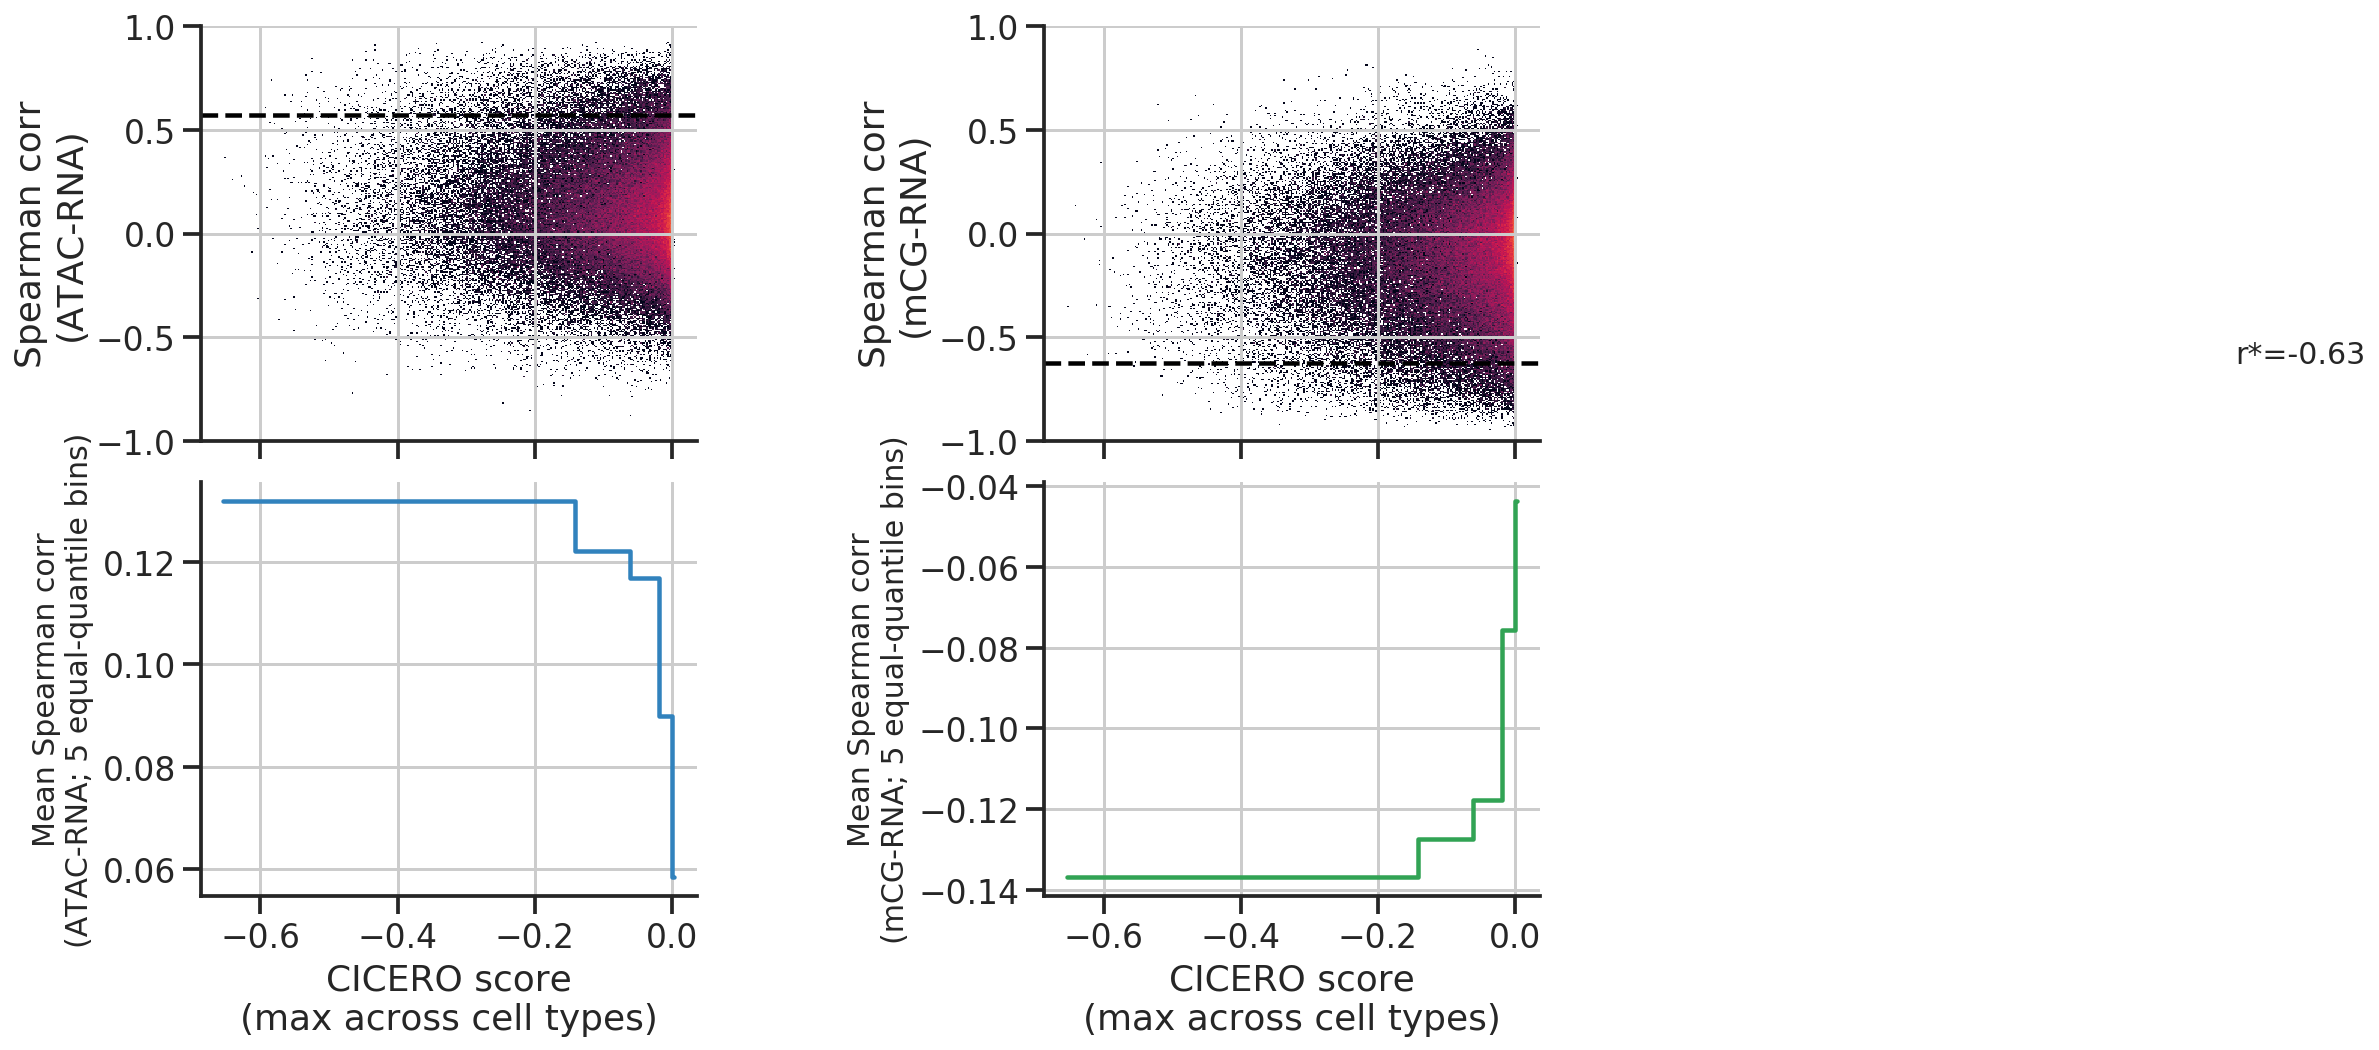

In [39]:
# data, x, y = merged_max, 'corr', 'powerlaw.Score'
qbins = 5

fig, axs = plt.subplots(2, 2, figsize=(6*2,4*2), sharex=True)
axs = axs.flat

ax = axs[0]
data, x, y = merged_max,  'coaccess', 'corr_atac',
powerplot.massive_scatterplot_withticks(ax, data, x, y, 300, 300, color_logscale=True)
ax.axhline(-res2_stats['r_th_linked'], color='black', linestyle='--')
ax.text(1.05, -res2_stats['r_th_linked'], 
        "r*={:.2g}".format(-res2_stats['r_th_linked']), 
        fontsize=15,
        )
ax.set_ylim([-1,1])
sns.despine(ax=ax)
ax.set_ylabel('Spearman corr\n(ATAC-RNA)')
ax.set_xlabel('')

ax = axs[1]
data, x, y = merged_max,  'coaccess', 'corr_mc',
powerplot.massive_scatterplot_withticks(ax, data, x, y, 300, 300, color_logscale=True)
ax.axhline(res_stats['r_th_linked'], color='black', linestyle='--')
ax.text(1.05, res_stats['r_th_linked'],
        "r*={:.2g}".format(res_stats['r_th_linked']), 
        fontsize=15,
        )
ax.set_ylim([-1,1])
sns.despine(ax=ax)
ax.set_ylabel('Spearman corr\n(mCG-RNA)')
ax.set_xlabel('')

ax = axs[2]
data, x, y = merged_max,  'coaccess', 'corr_atac',
_x, _y = get_mean_trend(data, x, y, qbins=qbins)
ax.plot(_x, _y, color=colors_atac[0])
sns.despine(ax=ax)
ax.set_ylabel('Mean Spearman corr\n(ATAC-RNA; {} equal-quantile bins)'.format(qbins), fontsize=15)
ax.set_xlabel('CICERO score\n(max across cell types)')

ax = axs[3]
data, x, y = merged_max,  'coaccess', 'corr_mc',
_x, _y = get_mean_trend(data, x, y, qbins=qbins)
ax.plot(_x, _y, color=colors_mc[0])
sns.despine(ax=ax)
ax.set_ylabel('Mean Spearman corr\n(mCG-RNA; {} equal-quantile bins)'.format(qbins), fontsize=15)
ax.set_xlabel('CICERO score\n(max across cell types)')

fig.subplots_adjust(wspace=0.7, hspace=0.1)
output = output_figures.format('fcicero_res1.pdf')
print(output)
snmcseq_utils.savefig(fig, output)
plt.show()

/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/figures/fig2_metacell_210818_r25.1_n256_fcicero_res2.pdf


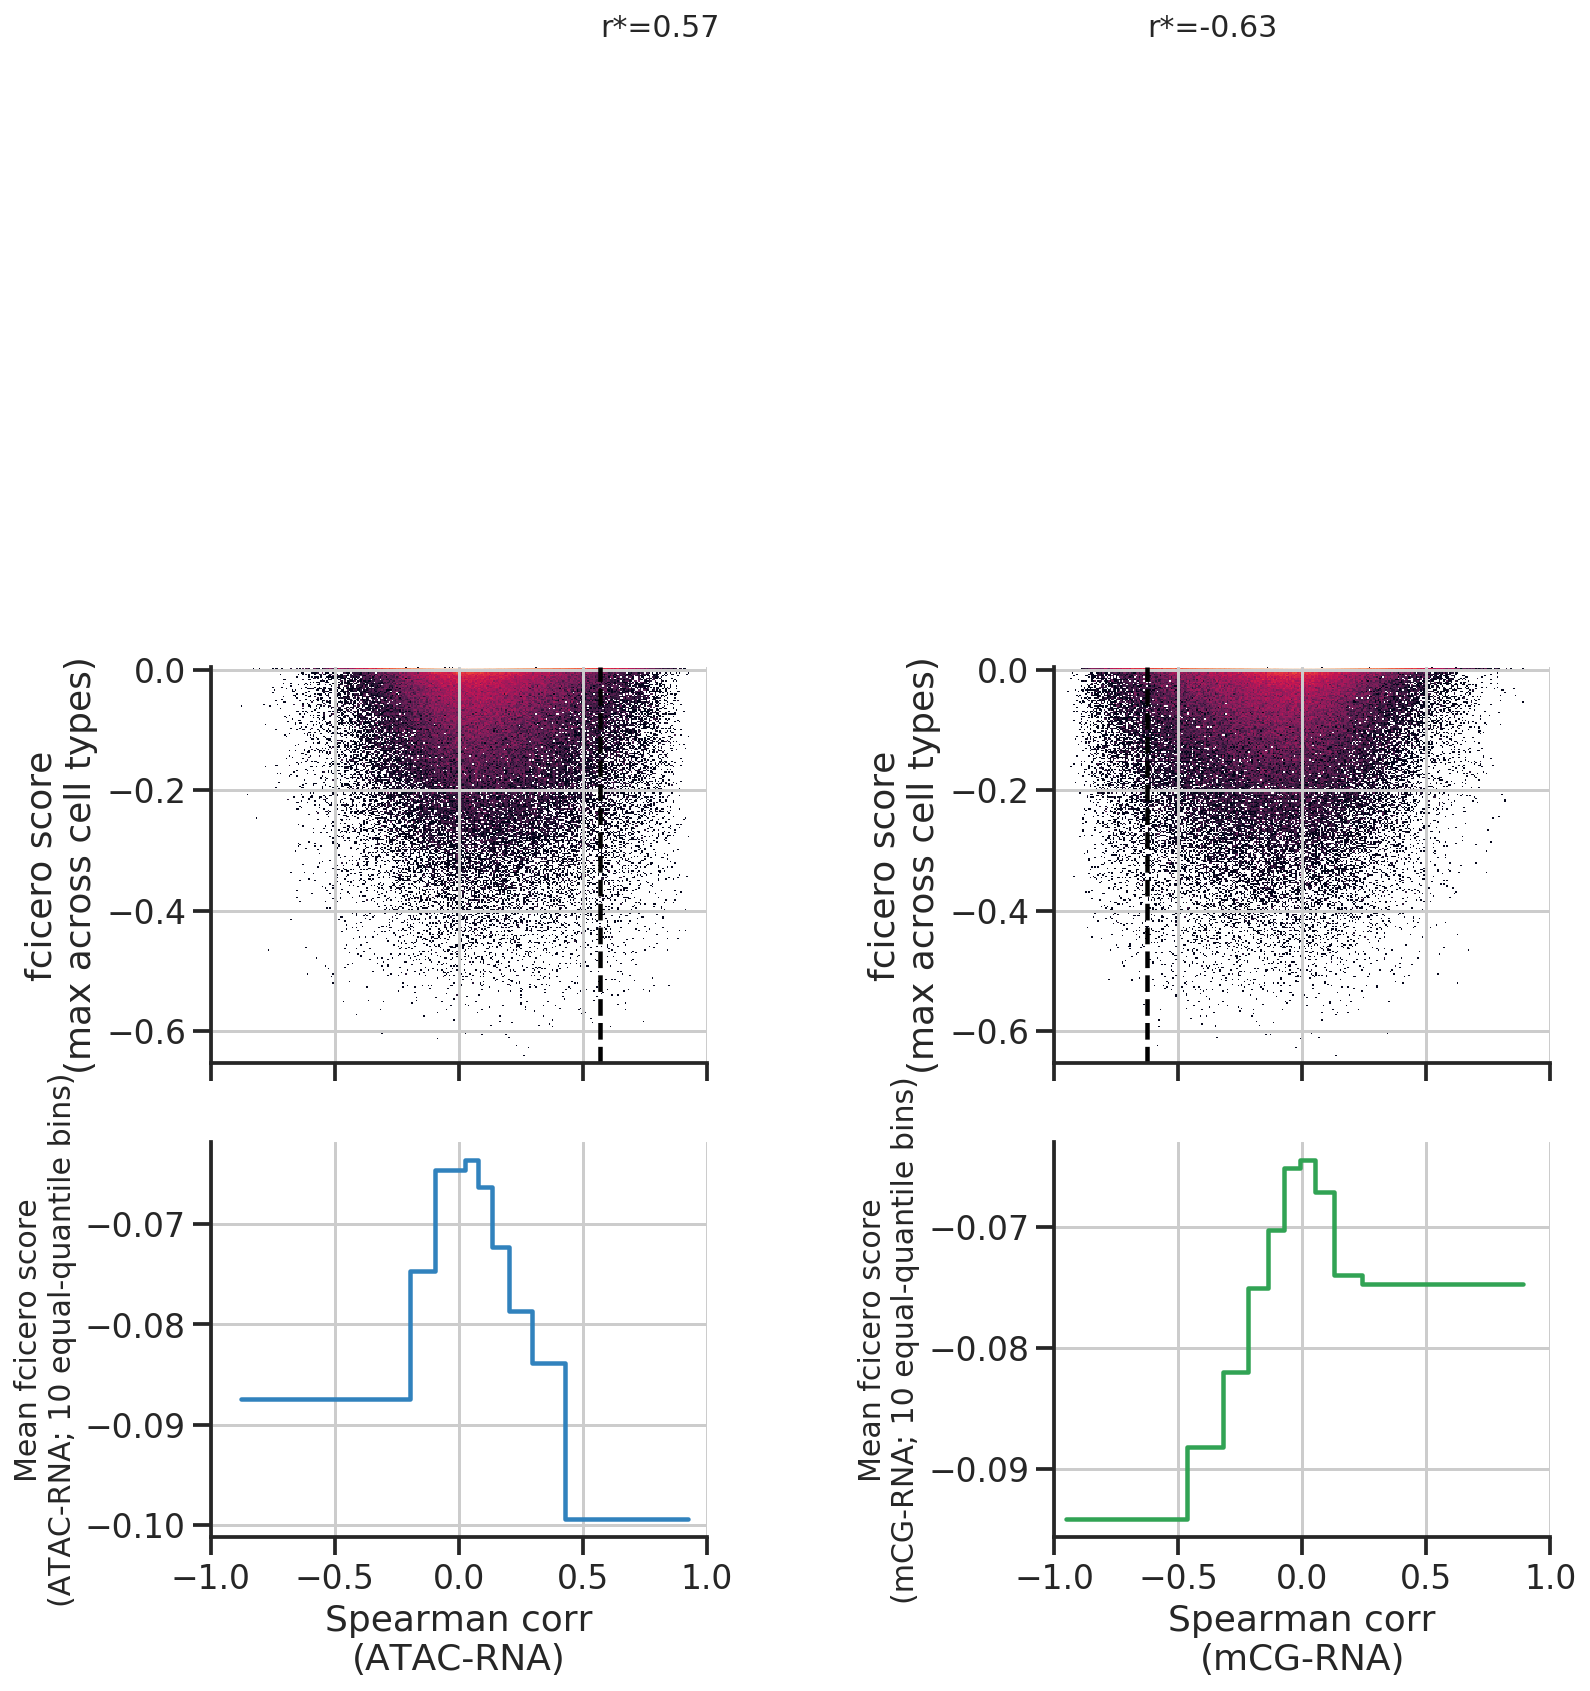

In [40]:
qbins = 10

fig, axs = plt.subplots(2, 2, figsize=(6*2,4*2), sharex=True)
axs = axs.flat

ax = axs[0]
data, x, y = merged_max, 'corr_atac', 'coaccess', 
powerplot.massive_scatterplot_withticks(ax, data, x, y, 300, 300, color_logscale=True)
ax.axvline(-res2_stats['r_th_linked'], color='black', linestyle='--')
ax.text(-res2_stats['r_th_linked'], 1.05, 
        "r*={:.2g}".format(-res2_stats['r_th_linked']), 
        fontsize=15,
        )
ax.set_xlim([-1,1])
sns.despine(ax=ax)
ax.set_xlabel('')
ax.set_ylabel('fcicero score\n(max across cell types)')

ax = axs[1]
data, x, y = merged_max, 'corr_mc', 'coaccess', 
powerplot.massive_scatterplot_withticks(ax, data, x, y, 300, 300, color_logscale=True)
ax.axvline(res_stats['r_th_linked'], color='black', linestyle='--')
ax.text(res_stats['r_th_linked'], 1.05, 
        "r*={:.2g}".format(res_stats['r_th_linked']), 
        fontsize=15,
        )
ax.set_xlim([-1,1])
sns.despine(ax=ax)
ax.set_xlabel('')
ax.set_ylabel('fcicero score\n(max across cell types)')

ax = axs[2]
data, x, y = merged_max, 'corr_atac', 'coaccess', 
_x, _y = get_mean_trend(data, x, y, qbins=qbins)
ax.plot(_x, _y, color=colors_atac[0])
sns.despine(ax=ax)
ax.set_xlabel('Spearman corr\n(ATAC-RNA)')
ax.set_ylabel('Mean fcicero score\n(ATAC-RNA; {} equal-quantile bins)'.format(qbins), fontsize=15)

ax = axs[3]
data, x, y = merged_max, 'corr_mc', 'coaccess',
_x, _y = get_mean_trend(data, x, y, qbins=qbins)
ax.plot(_x, _y, color=colors_mc[0])
sns.despine(ax=ax)
ax.set_xlabel('Spearman corr\n(mCG-RNA)')
ax.set_ylabel('Mean fcicero score\n(mCG-RNA; {} equal-quantile bins)'.format(qbins), fontsize=15)

fig.subplots_adjust(wspace=0.7, hspace=0.2)
output = output_figures.format('fcicero_res2.pdf')
print(output)
snmcseq_utils.savefig(fig, output)
plt.show()

# Simplified version
- correlated, linked, random

In [41]:
def mean_sem_routine(df):
    df = df.apply([np.mean, np.std, len])
    df.loc['sem'] = df.loc['std']/np.sqrt(df.loc['len'])
    df.loc['ci'] = 1.96*df.loc['sem']
    return df

# mC
fcicero_linked_mc = pd.merge(merged_max, 
         res_stats['linked_table'][['gene', 'enh_name']], 
         on=['gene', 'enh_name'])['coaccess'] 
fcicero_linked_mc = mean_sem_routine(fcicero_linked_mc)

fcicero_correlated_mc = pd.merge(merged_max, 
         res_stats['correlated_table'][['gene', 'enh_name']], 
         on=['gene', 'enh_name'])['coaccess']
fcicero_correlated_mc = mean_sem_routine(fcicero_correlated_mc)


# ATAC
fcicero_linked_atac = pd.merge(merged_max, 
         res2_stats['linked_table'][['gene', 'enh_name']], 
         on=['gene', 'enh_name'])['coaccess']
fcicero_linked_atac = mean_sem_routine(fcicero_linked_atac)

fcicero_correlated_atac = pd.merge(merged_max, 
         res2_stats['correlated_table'][['gene', 'enh_name']], 
         on=['gene', 'enh_name'])['coaccess']
fcicero_correlated_atac = mean_sem_routine(fcicero_correlated_atac)

# all
fcicero_none = merged_max['coaccess']
fcicero_none = mean_sem_routine(fcicero_none)


# both
linked_both = pd.merge(
    res_stats['linked_table'][['gene', 'enh_name']],
    res2_stats['linked_table'][['gene', 'enh_name']],
    on=['gene', 'enh_name'],
)
correlated_both = pd.merge(
    res_stats['correlated_table'][['gene', 'enh_name']],
    res2_stats['correlated_table'][['gene', 'enh_name']],
    on=['gene', 'enh_name'],
)
fcicero_linked_both = pd.merge(merged_max, linked_both,
                           on=['gene', 'enh_name'],
                           )['coaccess']
fcicero_linked_both = mean_sem_routine(fcicero_linked_both)

fcicero_correlated_both = pd.merge(merged_max, correlated_both,
                               on=['gene', 'enh_name'],
                              )['coaccess']
fcicero_correlated_both = mean_sem_routine(fcicero_correlated_both)

In [42]:
from scipy import stats

t, p1_mc = stats.ttest_ind_from_stats(
        fcicero_none['mean'], fcicero_none['std'], fcicero_none['len'], 
        fcicero_linked_mc['mean'], fcicero_linked_mc['std'], fcicero_linked_mc['len'], 
    )
t, p2_mc = stats.ttest_ind_from_stats(
        fcicero_none['mean'], fcicero_none['std'], fcicero_none['len'], 
        fcicero_correlated_mc['mean'], fcicero_correlated_mc['std'], fcicero_correlated_mc['len'], 
    )
t, p3_mc = stats.ttest_ind_from_stats(
        fcicero_correlated_mc['mean'], fcicero_correlated_mc['std'], fcicero_correlated_mc['len'], 
        fcicero_linked_mc['mean'], fcicero_linked_mc['std'], fcicero_linked_mc['len'], 
    )

t, p1_atac = stats.ttest_ind_from_stats(
        fcicero_none['mean'], fcicero_none['std'], fcicero_none['len'], 
        fcicero_linked_atac['mean'], fcicero_linked_atac['std'], fcicero_linked_atac['len'], 
    )
t, p2_atac = stats.ttest_ind_from_stats(
        fcicero_none['mean'], fcicero_none['std'], fcicero_none['len'], 
        fcicero_correlated_atac['mean'], fcicero_correlated_atac['std'], fcicero_correlated_atac['len'], 
    )
t, p3_atac = stats.ttest_ind_from_stats(
        fcicero_correlated_atac['mean'], fcicero_correlated_atac['std'], fcicero_correlated_atac['len'], 
        fcicero_linked_atac['mean'], fcicero_linked_atac['std'], fcicero_linked_atac['len'], 
    )

t, p1_both = stats.ttest_ind_from_stats(
        fcicero_none['mean'], fcicero_none['std'], fcicero_none['len'], 
        fcicero_linked_both['mean'], fcicero_linked_both['std'], fcicero_linked_both['len'], 
    )
t, p2_both = stats.ttest_ind_from_stats(
        fcicero_none['mean'], fcicero_none['std'], fcicero_none['len'], 
        fcicero_correlated_both['mean'], fcicero_correlated_both['std'], fcicero_correlated_both['len'], 
    )
t, p3_both = stats.ttest_ind_from_stats(
        fcicero_correlated_both['mean'], fcicero_correlated_both['std'], fcicero_correlated_both['len'], 
        fcicero_linked_both['mean'], fcicero_linked_both['std'], fcicero_linked_both['len'], 
    )

print(p1_mc, p2_mc, p3_mc, 
      p1_atac, p2_atac, p3_atac,
      p1_both, p2_both, p3_both,
     )


5.2416137302682305e-84 8.477514964553333e-39 2.3264951306975025e-53 6.362385597287714e-212 2.5259457885115795e-60 6.428853456024116e-140 7.811679605348634e-103 3.604713285919297e-113 1.4121587135172214e-55


/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/figures/fig2_metacell_210818_r25.1_n256_fcicero_bar.pdf


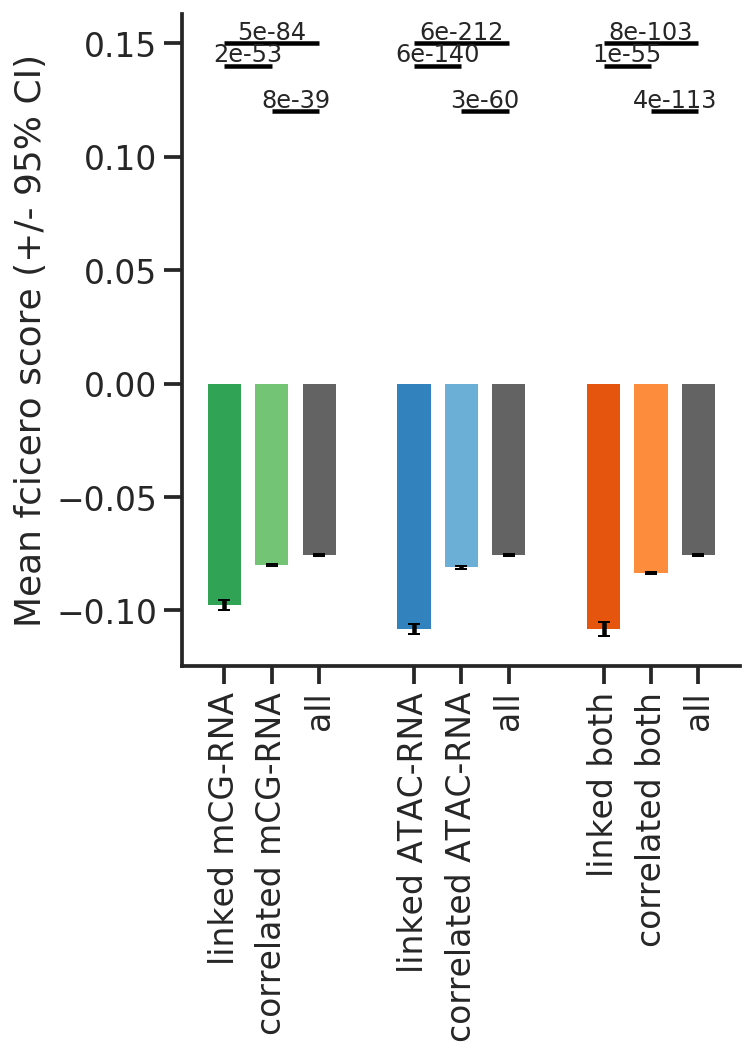

In [43]:
x = [0,1,2, 
     4,5,6,
     8,9,10,
    ]

xlabels = ['linked mCG-RNA', 'correlated mCG-RNA', 'all',
           'linked ATAC-RNA', 'correlated ATAC-RNA', 'all',
           'linked both', 'correlated both', 'all',
          ]
y = [fcicero_linked_mc.loc['mean'], fcicero_correlated_mc.loc['mean'], fcicero_none.loc['mean'],
     fcicero_linked_atac.loc['mean'], fcicero_correlated_atac.loc['mean'], fcicero_none.loc['mean'],
     fcicero_linked_both.loc['mean'], fcicero_correlated_both.loc['mean'], fcicero_none.loc['mean'],
    ] 
yerr = [fcicero_linked_mc.loc['ci'], fcicero_correlated_mc.loc['ci'], fcicero_none.loc['ci'],
        fcicero_linked_atac.loc['ci'], fcicero_correlated_atac.loc['ci'], fcicero_none.loc['ci'],
        fcicero_linked_both.loc['ci'], fcicero_correlated_both.loc['ci'], fcicero_none.loc['ci'],
       ]
cbar_kws = dict(width=0.7, edgecolor='none', capsize=3)
colors = [colors_mc[0], colors_mc[1], colors_null[1],
          colors_atac[0], colors_atac[1], colors_null[1],
          colors_both[0], colors_both[1], colors_null[1],
         ]

with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(5,6))
    ax.bar(x, y, yerr=yerr, color=colors, **cbar_kws)
    sns.despine(ax=ax)
    ax.set_ylabel('Mean fcicero score (+/- 95% CI)')
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels, rotation=90)

    # mC
    ax.hlines(0.15, 0, 2, colors='black')
    ax.text(1, 0.15+0.002, "{:.1g}".format(p1_mc), fontsize=12, ha='center')
    
    ax.hlines(0.12, 1, 2, colors='black')
    ax.text(1.5, 0.12+0.002, "{:.1g}".format(p2_mc), fontsize=12, ha='center')
    
    ax.hlines(0.14, 0, 1, colors='black')
    ax.text(0.5, 0.14+0.002, "{:.1g}".format(p3_mc), fontsize=12, ha='center')

    
    # ATAC
    ax.hlines(0.15, 4, 6, colors='black')
    ax.text(5, 0.15+0.002, "{:.1g}".format(p1_atac), fontsize=12, ha='center')
    
    ax.hlines(0.12, 5, 6, colors='black')
    ax.text(5.5, 0.12+0.002, "{:.1g}".format(p2_atac), fontsize=12, ha='center')
    
    ax.hlines(0.14, 4, 5, colors='black')
    ax.text(4.5, 0.14+0.002, "{:.1g}".format(p3_atac), fontsize=12, ha='center')
    
    # both
    ax.hlines(0.15, 8, 10, colors='black')
    ax.text(9, 0.15+0.002, "{:.1g}".format(p1_both), fontsize=12, ha='center')
    
    ax.hlines(0.12, 9, 10, colors='black')
    ax.text(9.5, 0.12+0.002, "{:.1g}".format(p2_both), fontsize=12, ha='center')
    
    ax.hlines(0.14, 8, 9, colors='black')
    ax.text(8.5, 0.14+0.002, "{:.1g}".format(p3_both), fontsize=12, ha='center')

    output = output_figures.format('fcicero_bar.pdf')
    print(output)
    snmcseq_utils.savefig(fig, output)
    plt.show()

# Venn diagram 

In [44]:
fcicero_th = 0.2
fcicero_pairs = merged_max[merged_max['coaccess'] > fcicero_th][['gene', 'enh_name']].agg('-'.join, axis=1)

mc_linked_pairs = res_stats['linked_table'][['gene', 'enh_name']].agg('-'.join, axis=1)
mc_correlated_pairs = res_stats['correlated_table'][['gene', 'enh_name']].agg('-'.join, axis=1)

atac_linked_pairs = res2_stats['linked_table'][['gene', 'enh_name']].agg('-'.join, axis=1)
atac_correlated_pairs = res2_stats['correlated_table'][['gene', 'enh_name']].agg('-'.join, axis=1)


fcicero_pairs = set(fcicero_pairs)

mc_linked_pairs = set(mc_linked_pairs)
mc_correlated_pairs = set(mc_correlated_pairs)

atac_linked_pairs = set(atac_linked_pairs)
atac_correlated_pairs = set(atac_correlated_pairs)

/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/matplotlib_venn/_venn3.py:53: UserWarning: Circle A has zero area
  warnings.warn("Circle A has zero area")


AttributeError: 'NoneType' object has no attribute 'set_text'

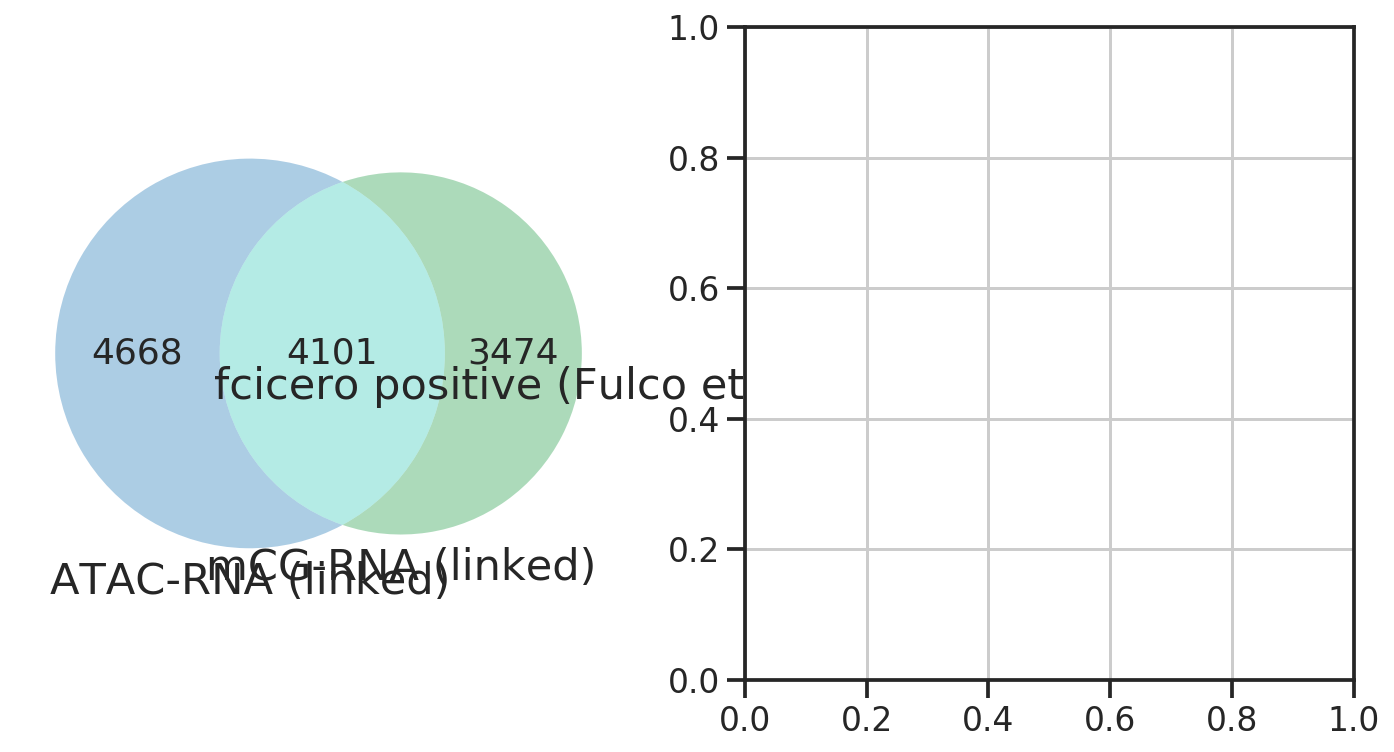

In [45]:
output = output_figures.format('fcicero_venn.pdf')

title = ''
ref_area = len(fcicero_pairs|atac_linked_pairs|mc_linked_pairs) #|correlated_pairs)

fig, axs = plt.subplots(1,2,figsize=(2*6,1*6))
ax = axs[0]
venn_ax(ax, title, 
        [fcicero_pairs, atac_linked_pairs, mc_linked_pairs], 
        ['fcicero positive (Fulco et al. 2019)', 'ATAC-RNA (linked)', 'mCG-RNA (linked)'], 
        [colors_null[1], colors_atac[0], colors_mc[0]], 
       )
true_area = len(fcicero_pairs|atac_linked_pairs|mc_linked_pairs)
enhancer_gene_utils.set_venn_scale(ax, true_area, ref_area)

ax = axs[1]
venn_ax(ax, title, 
        [fcicero_pairs, atac_correlated_pairs, mc_correlated_pairs], 
        ['fcicero positive (Fulco et al. 2019)', 'ATAC-RNA (correlated)', 'mCG-RNA (correlated)'], 
        [colors_null[1], colors_atac[0], colors_mc[0]], 
       )
true_area = len(fcicero_pairs|atac_correlated_pairs|mc_correlated_pairs)
enhancer_gene_utils.set_venn_scale(ax, true_area, ref_area)

fig.subplots_adjust(wspace=0)
print(output)
snmcseq_utils.savefig(fig, output)
plt.show()

In [ ]:
fcicero_pairs